In [16]:
# import the nptdms module
import nptdms
import numpy as np
import matplotlib.pyplot as plt


In [17]:
ADCS = ['A', 'B', 'C', 'D', 'E', 'F']

START = 95005

adc_data_raw = {}
min_length = float('inf')

for adc in ADCS:
    adc_file = nptdms.TdmsFile("ADC_"+adc+".tdms")
    adc_data_raw[adc] = np.array(adc_file['Untitled']['Untitled'][START:])
    print(f'ADC {adc} data len: {len(adc_data_raw[adc])}')
    min_length = min(min_length, len(adc_data_raw[adc]))

del adc_file
    
# wit 33480895 takes 1m 30s to 2m 

ADC A data len: 36060495
ADC B data len: 36060395
ADC C data len: 36061295
ADC D data len: 36061295
ADC E data len: 36062195
ADC F data len: 36062395


In [18]:
# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 5)
    Q3 = np.percentile(data, 95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]


# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

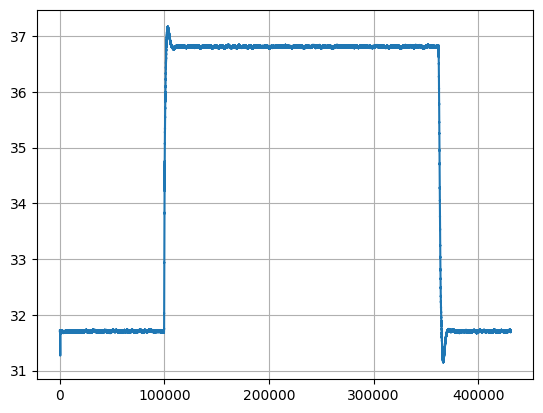

In [19]:
import pandas as pd

# Read the data from the file
data = pd.read_csv('burden_temperature_1411.txt', sep='\t')

# Assuming the resistance values are in the 'Amplitude - Plot 0' column
resistance_values = data['Amplitude - Plot 0']

# Calculate temperature in degrees Celsius using the linear relationship
def resistance_to_temperature(resistance):
    return (resistance - 100) / 0.385

# Apply the conversion function to the resistance values
temperature_burden = resistance_values.apply(resistance_to_temperature)[:-500]

# Plot the temperature values
temperature_burden.plot()
plt.grid()
plt.show()



std of temp normalized: 0.03556675248767209


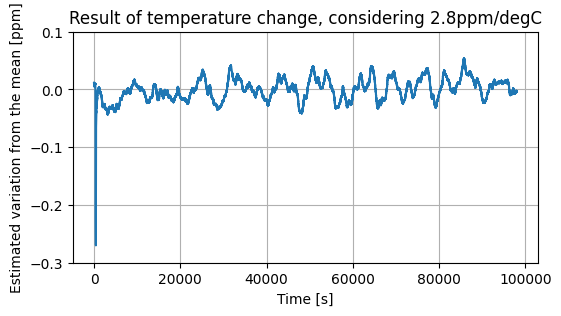

In [61]:
# considering a 2.5 ppm per deg C temperature coefficient for the resistor, plot the contribution to the error 

plt.figure(figsize=(6,3))

temp_normalized = temperature_burden - np.mean(temperature_burden[1000:98000])

plt.plot(centered_moving_average(temp_normalized[:98000]*2.8,100))
plt.title('Result of temperature change, considering 2.8ppm/degC')
plt.xlabel('Time [s]')
plt.ylabel('Estimated variation from the mean [ppm]')

print(f'std of temp normalized: {2*np.std(centered_moving_average(temp_normalized[5000:98000]*2.8,100))}')

# set y ticks
plt.yticks(np.arange(-0.3, 0.2, 0.1))
plt.grid()

plt.savefig('6_result_of_temp_on_ppm.png', dpi = 300, bbox_inches='tight')
plt.show()



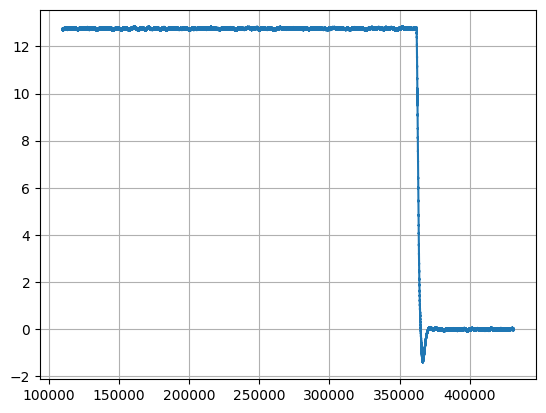

In [21]:


plt.plot(temp_normalized[110000:]*2.5)
plt.grid()
plt.show()




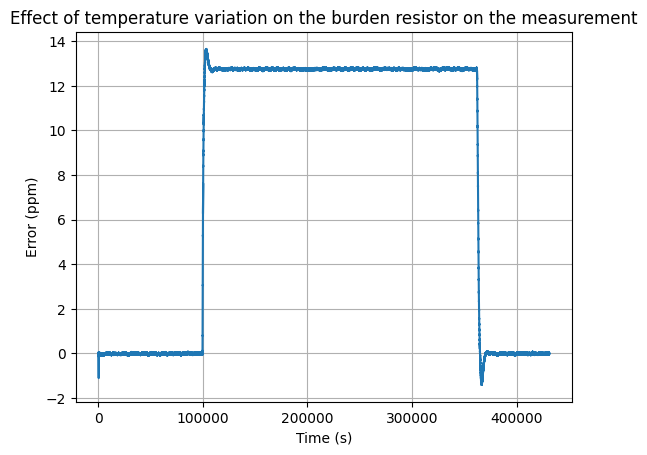

In [22]:

plt.plot(temp_normalized*2.5)

plt.title('Effect of temperature variation on the burden resistor on the measurement')
plt.xlabel('Time (s)')
plt.ylabel('Error (ppm)')
plt.grid()
plt.show()

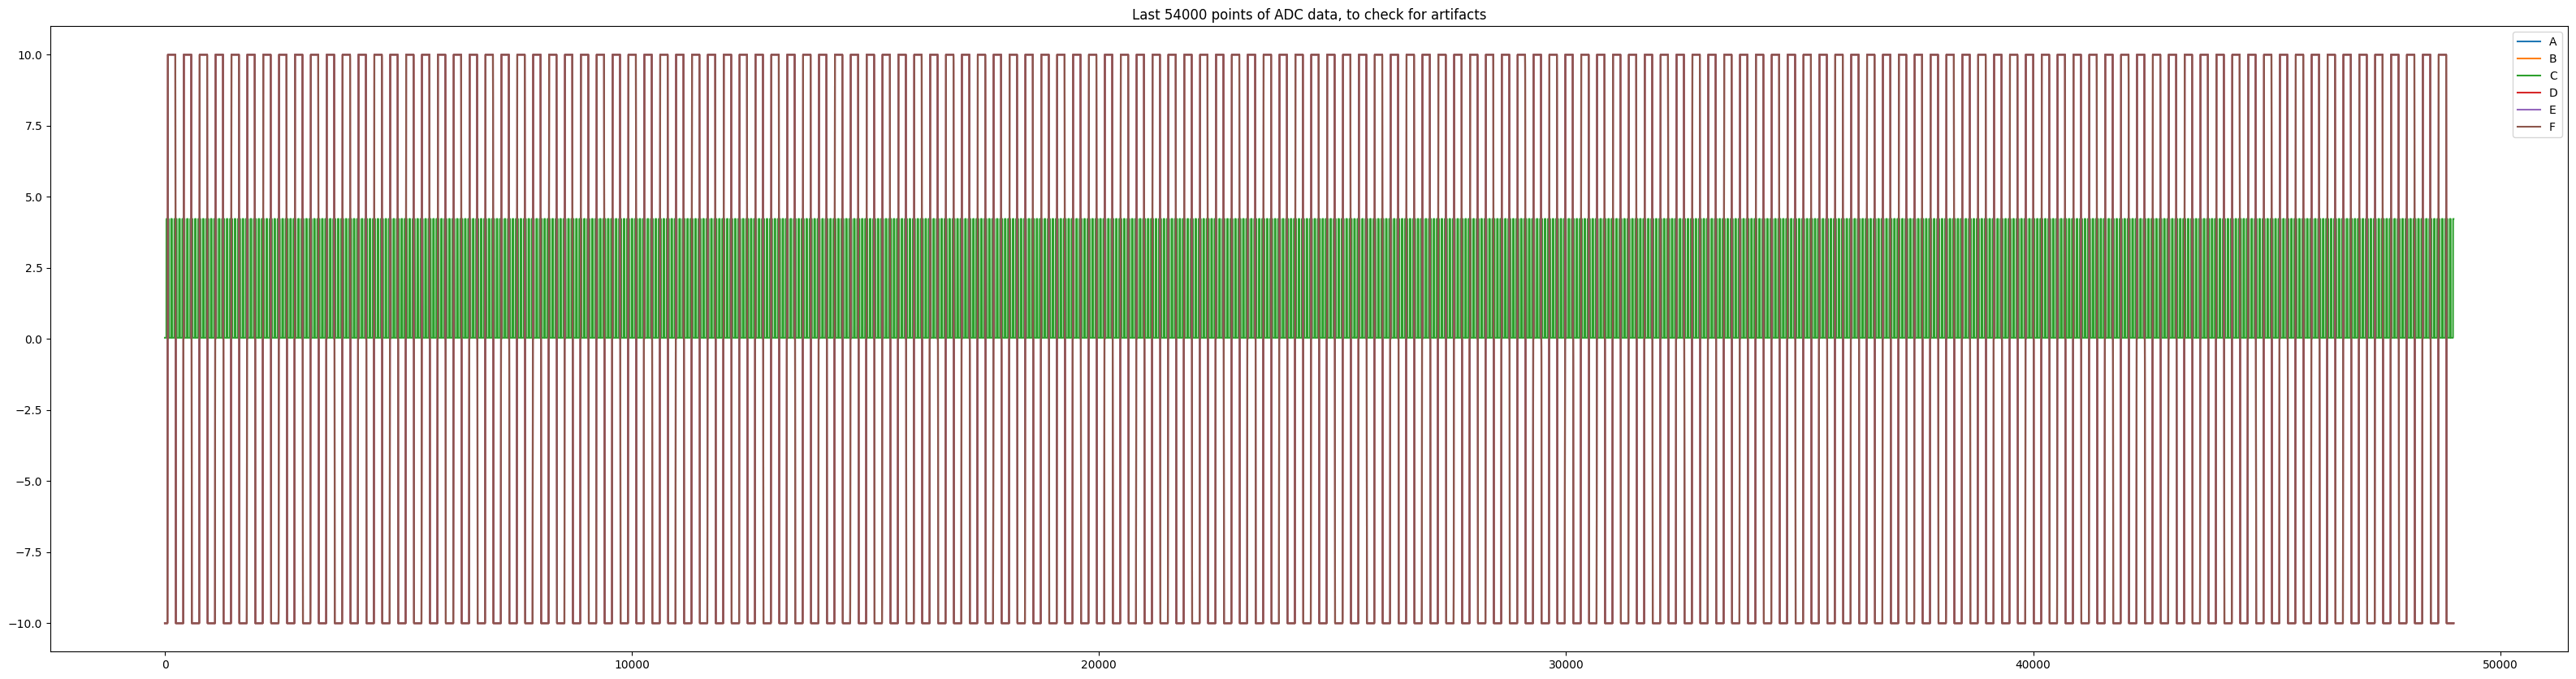

In [23]:


# plot the data for all ADCS from 100000 to 100500
plt.figure(figsize=(40,10))

adc_data = {}
# crop all adc channel data to the shortest one, and throw out the last 4000 points


for adc in ADCS:
    adc_data[adc] = adc_data_raw[adc][:min_length-55000]
    plt.plot(adc_data[adc][min_length-104000:])

plt.legend(ADCS)
plt.title('Last 54000 points of ADC data, to check for artifacts')
plt.show()


del adc_data_raw



[ 82 152 252 322 422 492]
[ 83 153 253 323 423 493]
Cropping ADC A between 25694362 and 25699388, scrapping 5026 points
Cropping ADC B between 25694362 and 25699388, scrapping 5026 points
Cropping ADC C between 25694362 and 25699388, scrapping 5026 points
Cropping ADC D between 25694362 and 25699388, scrapping 5026 points
Cropping ADC E between 25694362 and 25699388, scrapping 5026 points
Cropping ADC F between 25694362 and 25699388, scrapping 5026 points


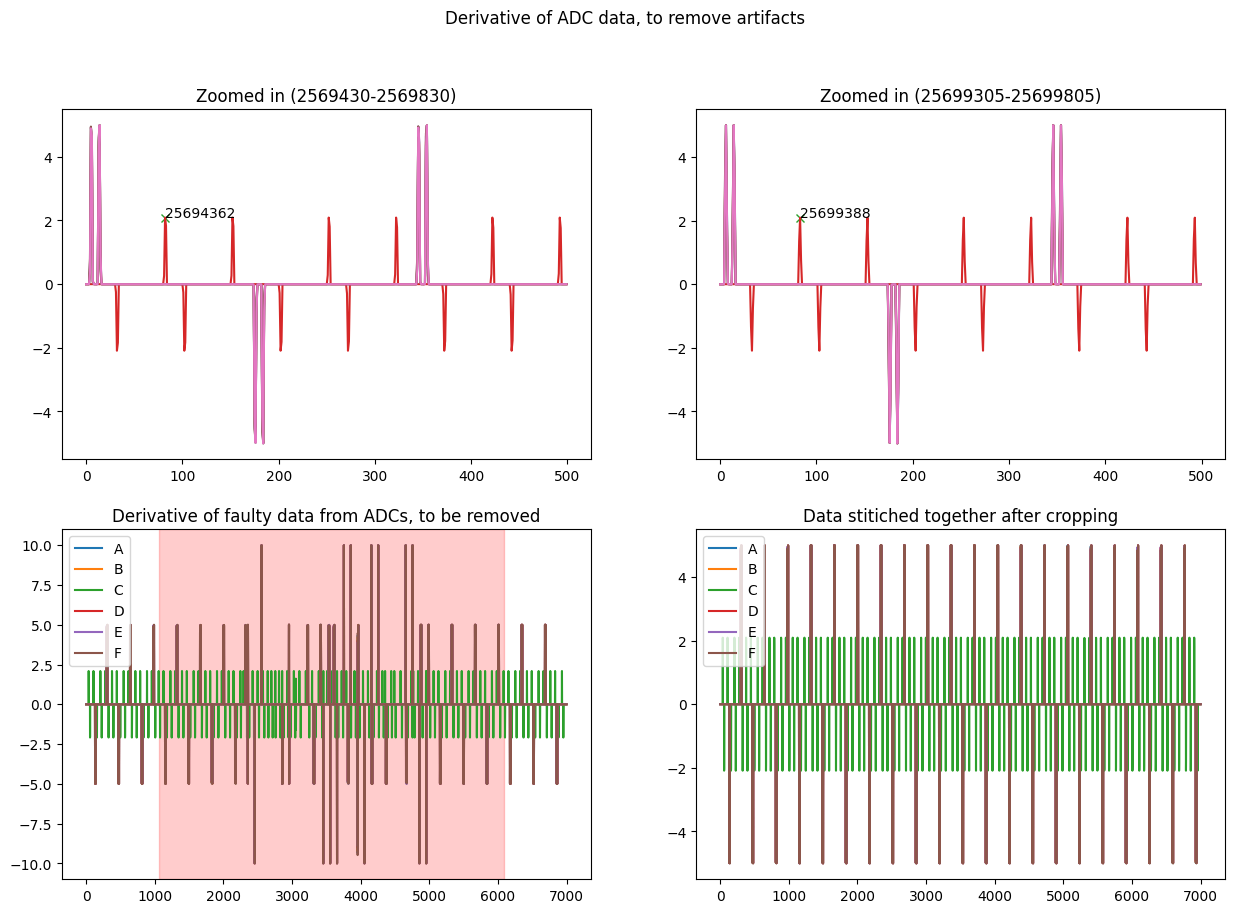

In [24]:
# plot the derivative of the data for all ADCS from 100000 to 100500
plt.figure(figsize=(15, 10))
plt.suptitle('Derivative of ADC data, to remove artifacts')

from scipy.signal import find_peaks

# Top left plot
plt.subplot(2, 2, 1)
for adc in ADCS:
    data_range = adc_data[adc][25694280:25694780]
    derivative = np.gradient(data_range)
    if adc == 'C':
        peaks, _ = find_peaks(derivative, threshold=0.1)
        print(peaks)
        plt.plot(peaks[0], derivative[peaks[0]], 'x')
        plt.text(peaks[0], derivative[peaks[0]], str(peaks[0]+25694280))
        start_peak = peaks[0]+25694280
    plt.plot(derivative)

plt.title("Zoomed in (2569430-2569830)")

# Top right plot
plt.subplot(2, 2, 2)
for adc in ADCS:
    data_range = adc_data[adc][25699305:25699805]
    derivative = np.gradient(data_range)
    if adc == 'C':
        peaks, _ = find_peaks(derivative, threshold=0.1)
        print(peaks)
        plt.plot(peaks[0], derivative[peaks[0]], 'x')
        plt.text(peaks[0], derivative[peaks[0]], str(peaks[0]+25699305))
        end_peak = 83+25699305
    plt.plot(derivative)

plt.title("Zoomed in (25699305-25699805)")

# Bottom left plot
plt.subplot(2, 2, 3)
for adc in ADCS:
    data_range = adc_data[adc][25693305:25668305+32000]
    derivative = np.gradient(data_range)
    plt.plot(derivative)

start_peak_index = start_peak - 25693305
end_peak_index = end_peak - 25693305
# highlight the data to be removed with a x axis span
plt.axvspan(start_peak_index, end_peak_index, color='red', alpha=0.2)
plt.legend(ADCS)
plt.title("Derivative of faulty data from ADCs, to be removed")

adc_data_trim = {adc: [] for adc in ADCS}

for adc in ADCS:
    print(f'Cropping ADC {adc} between {start_peak} and {end_peak}, scrapping {end_peak-start_peak} points')
    adc_data_trim[adc] = np.concatenate( [ adc_data[adc][:start_peak] , adc_data[adc][end_peak:] ] )


# Bottom right plot
plt.subplot(2, 2, 4)

for adc in ADCS:
    data_range = adc_data_trim[adc][25693305:25668305+32000]
    derivative = np.gradient(data_range)
    plt.plot(derivative)

plt.legend(ADCS)
plt.title("Data stitiched together after cropping")

plt.show() 

 



In [25]:


# Assuming trigger_data is an array of trigger signal values
trigger_data = np.array(adc_data_trim['C'])  # Use ADC C as trigger data

DATA_ADCS = ['A', 'B', 'D', 'E', 'F']  # ADCs that contain data

# Define thresholds
low_state_threshold = 1.0  # Threshold for low state
high_state_min_duration = 22  # Minimum duration for a high state to be considered 'long'

# Identify indices where trigger is in low state
low_state_indices = np.where(trigger_data < low_state_threshold)[0]

# Identify long high state periods
high_state_indices = np.where(trigger_data >= low_state_threshold)[0]
high_state_windows = np.split(high_state_indices, np.where(np.diff(high_state_indices) != 1)[0] + 1)
long_high_state_indices = [window for window in high_state_windows if len(window) >= high_state_min_duration]

# Process each ADC data
adc_averages = {adc: [] for adc in DATA_ADCS}

# Find valid low state windows considering long high states
valid_low_state_windows = []
for i in range(len(long_high_state_indices) - 1):
    start = long_high_state_indices[i][-1] + 1
    end = long_high_state_indices[i + 1][0]
    valid_low_state_window = np.arange(start, end)
    valid_low_state_windows.append(valid_low_state_window)


# Process valid low state windows
for window in valid_low_state_windows:
    if len(window) == 0:
        continue
    for adc in DATA_ADCS:
        adc_average = np.mean(adc_data_trim[adc][window])
        adc_averages[adc].append(adc_average)


# Plot the averages

del adc_data_trim

211783
211783
211783
211783
211783
211783


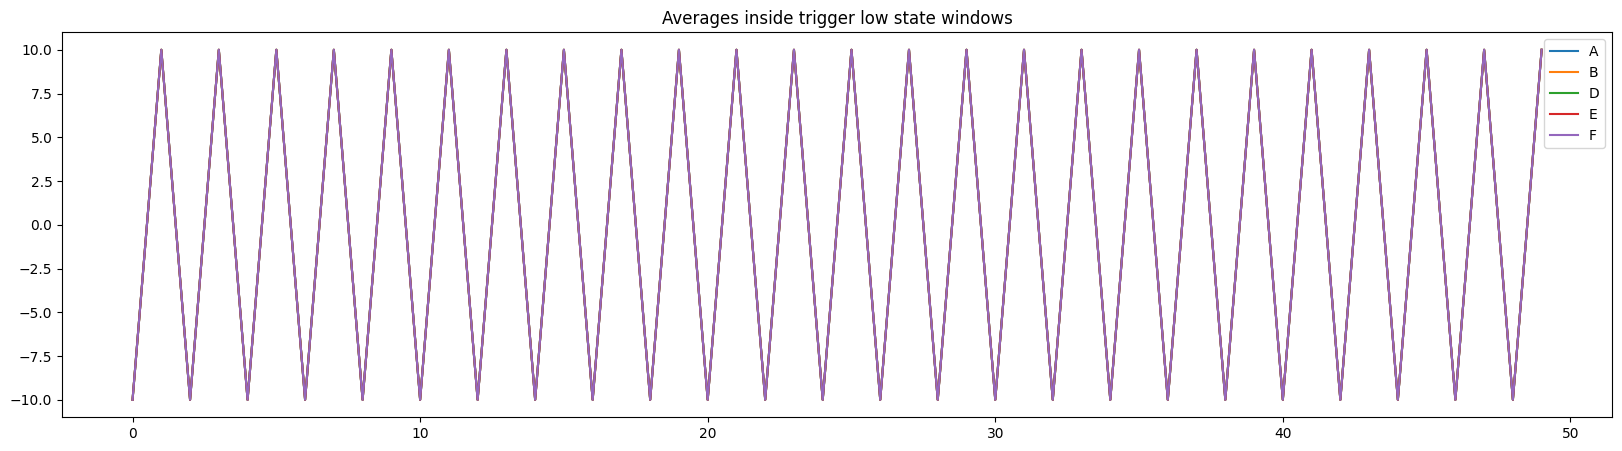

In [26]:
print(len(adc_averages['A']))

plt.figure(figsize=(20, 5))
# Plot the results
for adc in DATA_ADCS:
    plt.plot(adc_averages[adc][-50:])
    print(len(adc_averages[adc]))

plt.legend(DATA_ADCS)
plt.title("Averages inside trigger low state windows")
plt.show()



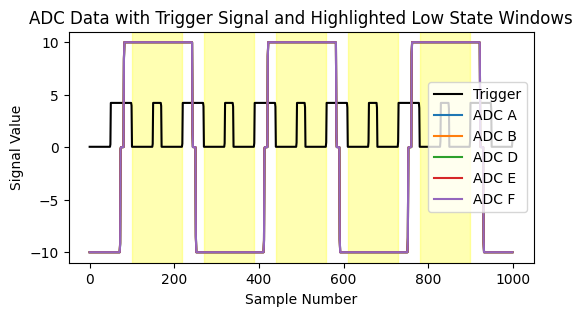

In [47]:

# Plotting the results
plt.figure(figsize=(6, 3))


time_in_seconds = np.arange(0, len(adc_data[adc][:1000]) * 0.1, 0.1)

# Plot the trigger data
plt.plot(trigger_data[:1000], label='Trigger', color='black')

# Highlight valid low state windows
for window in valid_low_state_windows:
    if len(window) > 0 and window[-1] < 1000:
        plt.axvspan(window[0], window[-1], color='yellow', alpha=0.3)

# Plot a sample of the ADC data
for adc in DATA_ADCS:
    plt.plot(adc_data[adc][:1000], label=f'ADC {adc}')
    ...

plt.legend()
plt.title("ADC Data with Trigger Signal and Highlighted Low State Windows")
plt.xlabel("Sample Number")
plt.ylabel("Signal Value")
plt.savefig('6_adc_data_with_trigger_windows.png', dpi = 300, bbox_inches='tight')
plt.show()



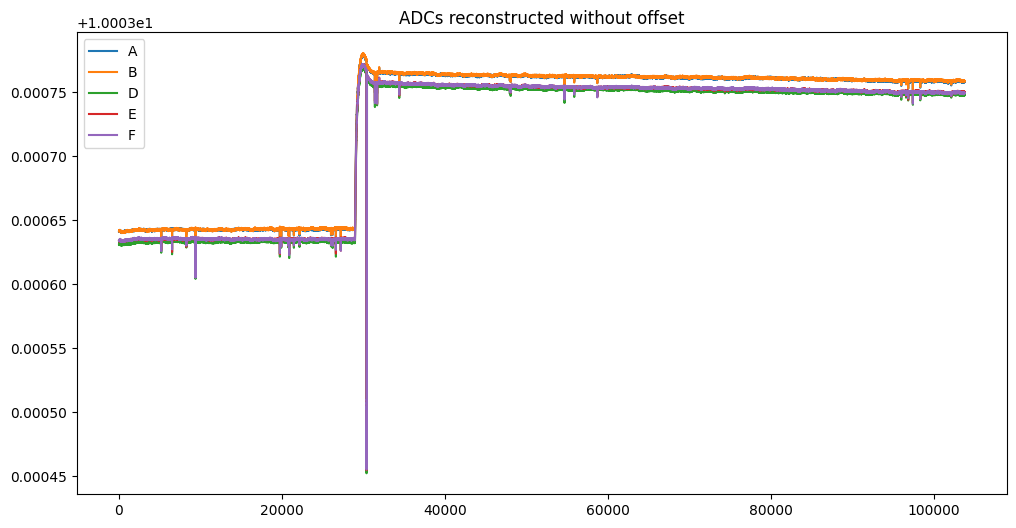

In [28]:
plt.figure(figsize=(12, 6))

v_meas_nooffset = {adc: [] for adc in DATA_ADCS}

for adc in DATA_ADCS:
    v_meas_nooffset[adc] = [(-adc_averages[adc][i] + adc_averages[adc][i+1])/2 for i in range(1, len(adc_averages[adc])-1, 2)]
    
TRIM = 2000


adc_no_offset = {adc: [] for adc in DATA_ADCS}  
# remove outliers
for adc in DATA_ADCS:
    adc_no_offset[adc] = np.array(v_meas_nooffset[adc])[:-TRIM]

for adc in DATA_ADCS:
    plt.plot(remove_outliers(adc_no_offset[adc]))

plt.title("ADCs reconstructed without offset")
plt.legend(DATA_ADCS)
plt.show()

<Figure size 1200x600 with 0 Axes>

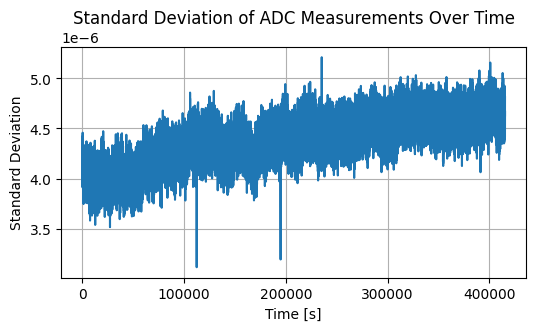

In [51]:
plt.figure(figsize=(12, 6))
# Initialize a list to store the standard deviations
standard_deviations = []

# Calculate standard deviation at each time step
for i in range(len(adc_no_offset['A'])):  # Assuming all channels have the same length
    values_at_time_i = [adc_no_offset[adc][i] for adc in DATA_ADCS]
    std_dev = np.std(values_at_time_i)
    standard_deviations.append(std_dev)

standard_deviations = np.array(standard_deviations)

time_in_seconds = np.arange(0, len(standard_deviations) * 4, 4)


# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(time_in_seconds[:len(remove_outliers(standard_deviations))], remove_outliers(standard_deviations))
plt.title("Standard Deviation of ADC Measurements Over Time")
plt.xlabel("Time [s]")
plt.ylabel("Standard Deviation")
plt.savefig('6_standard_deviations_hpms.png', dpi = 300, bbox_inches='tight')
plt.grid()
plt.show()

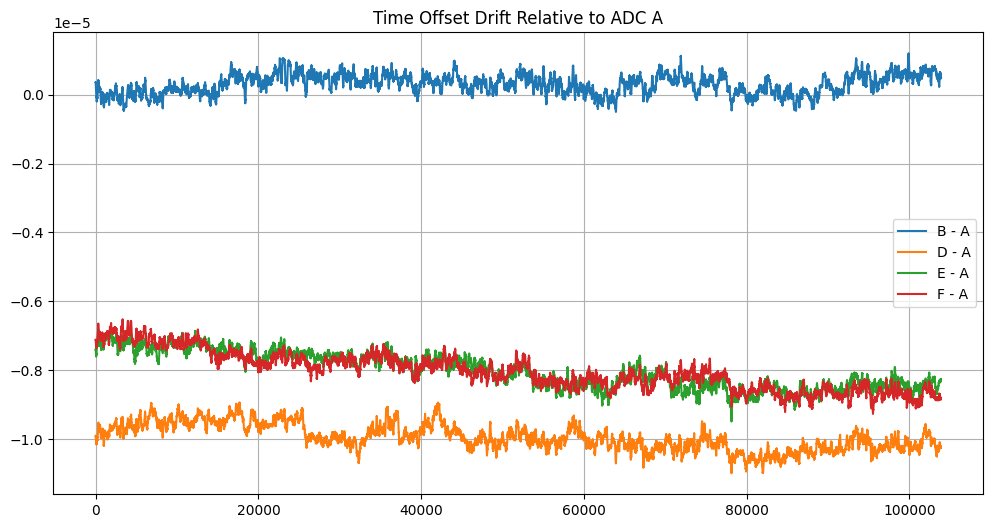

In [30]:
plt.figure(figsize=(12, 6))

# Choose one channel as a reference, for example, ADC A
reference_adc = 'A'
reference_signal = adc_no_offset[reference_adc]

# Plot the differences with respect to the reference channel
for adc in DATA_ADCS:
    if adc != reference_adc:
        # Calculate the difference between the current ADC and the reference ADC
        difference = np.array(adc_no_offset[adc]) - np.array(reference_signal)

        # Plot the difference
        plt.plot(centered_moving_average(remove_outliers(difference),100), label=f'{adc} - {reference_adc}')

plt.title(f"Time Offset Drift Relative to ADC {reference_adc}")
plt.legend()
plt.grid()
plt.show()

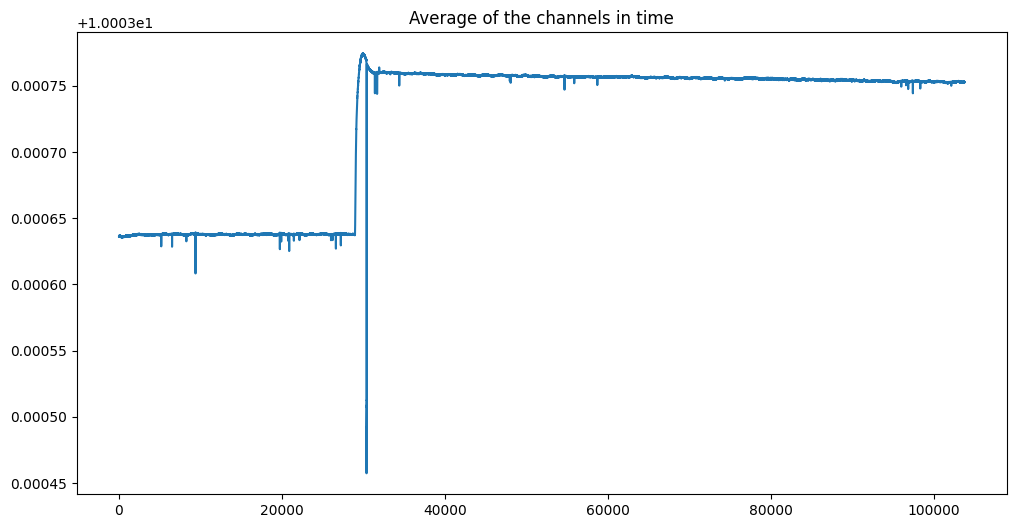

In [31]:
plt.figure(figsize=(12, 6))

# calculate the average of the channels in time
averages_calc = []


for i in range(len(adc_no_offset[DATA_ADCS[0]])):
    average = 0
    for adc in DATA_ADCS:
        average += adc_no_offset[adc][i]
    averages_calc.append(average/len(DATA_ADCS))

averages = remove_outliers(np.array(averages_calc))

# plot the average of the channels in time
plt.plot(averages)


plt.title("Average of the channels in time")


plt.show()



10.00363776600527


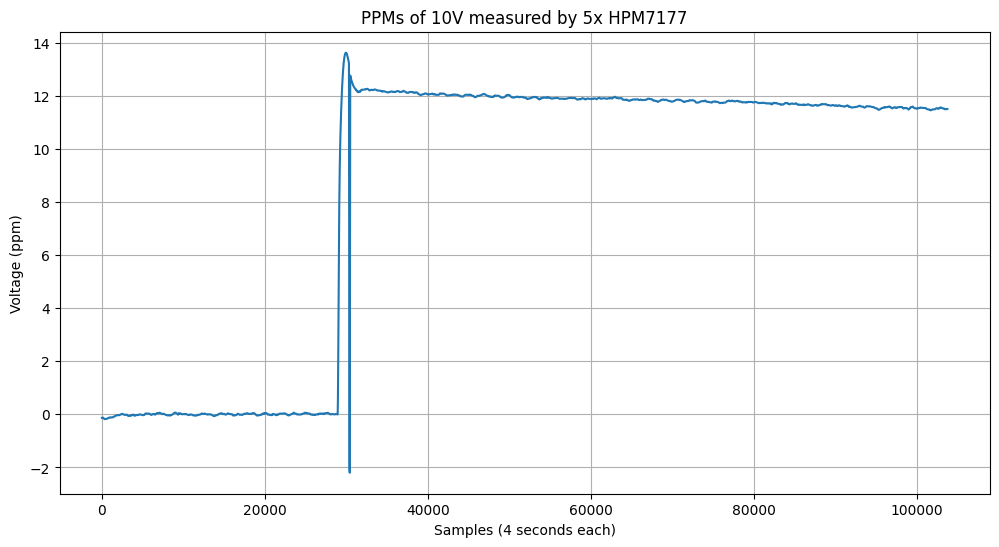

In [32]:
# generate the baseline: average over the first 25000 samples
baseline = np.mean(averages[2500:25000])
print(baseline)


averages_ppm = [((averages[i] -baseline)/baseline)*1e6 for i in range(len(averages))]


# add a box in the plot with the standard deviation figure
plt.figure(figsize=(12, 6))

# average every 4 values of temperature_burden


plt.plot(centered_moving_average(averages_ppm, 100))


plt.title('PPMs of 10V measured by 5x HPM7177')
plt.xlabel('Samples (4 seconds each)')
plt.ylabel('Voltage (ppm)')
plt.grid()
plt.show()

import csv

with open("6_run_hpm7177.csv", 'w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(["mean"])
    for i in range(len(averages_ppm)):
        writer.writerow([averages_ppm[i]])

0.027844542938085998
Three sigma peak to peak: 0.2505016281438416
Three sigma 2500 peak to peak: 0.16706725762851599


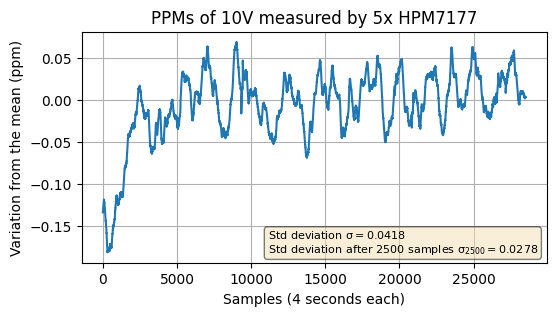

In [59]:


# add a box in the plot with the standard deviation figure
plt.figure(figsize=(6, 3))

plt.plot(centered_moving_average(averages_ppm[:28500],100))

std = np.std(centered_moving_average(averages_ppm[:28500],100))

# assess the standard deviation of the data after sample 2500
std2500 = np.std(centered_moving_average(averages_ppm[2500:28500],100))
print(std2500)

print(f'Three sigma peak to peak: {6*std}')
print(f'Three sigma 2500 peak to peak: {6*std2500}')
# add these figures to a box in the bottom left corner
textstr = '\n'.join((
    r'$\mathrm{Std\ deviation\ \sigma}=%.4f$' % std,
    r'$\mathrm{Std\ deviation\ after\ 2500\ samples\ \sigma_{2500}}=%.4f$' % std2500, ))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


plt.text(0.4, 0.15, textstr, transform=plt.gca().transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

plt.title('PPMs of 10V measured by 5x HPM7177')
plt.xlabel('Samples (4 seconds each)')
plt.ylabel('Variation from the mean (ppm)')
plt.grid()
plt.savefig('6_run_hpm7177_stability.png', dpi = 300, bbox_inches='tight')
plt.show()

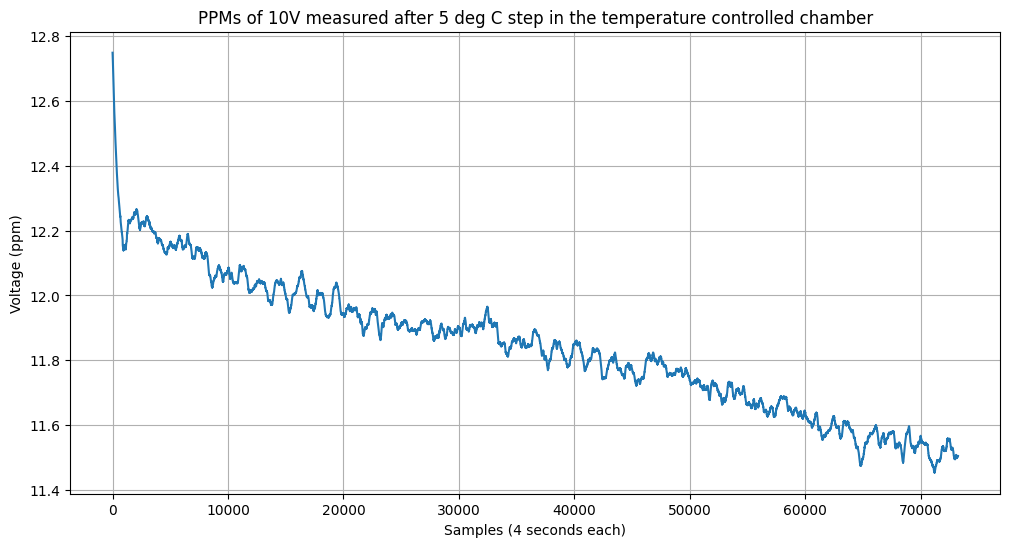

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(centered_moving_average(averages_ppm[30470:30470+75000],100))
plt.title('PPMs of 10V measured after 5 deg C step in the temperature controlled chamber')
plt.xlabel('Samples (4 seconds each)')
plt.ylabel('Voltage (ppm)')
plt.grid()
plt.show()

In [35]:
plt.figure(figsize=(12, 6))

plt.plot(centered_moving_average(averages_ppm[30470+75000+3000:],100))
plt.title('PPMs of 10V measured after restoring the temperature controlled chamber')
plt.xlabel('Samples (4 seconds each)')
plt.ylabel('Voltage (ppm)')
plt.grid()
plt.show()

ValueError: can't extend empty axis 0 using modes other than 'constant' or 'empty'

<Figure size 1200x600 with 0 Axes>